In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse as dateutil_parser

from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

DATA_PATH = './data/'

%matplotlib inline

In [2]:
clean_play = pd.read_csv(DATA_PATH+'naive/play.csv',index_col=0)
clean_download = pd.read_csv(DATA_PATH+'naive/download.csv',index_col=0)
clean_like = pd.read_csv(DATA_PATH+'naive/like.csv',index_col=0)
song = pd.read_csv(DATA_PATH+'mars_tianchi_songs.csv')

In [3]:
song.index = song.song_id
all_songs = song.loc[:,['song_init_plays']]
all_songs['howold'] = (song['publish_time'].map(lambda x: dateutil_parser(str(x))) - dateutil_parser('20150301')).map(lambda x: x.days)
lang = pd.get_dummies(song['Language'],'lang').applymap(lambda x: True if x==1 else False)
gender = pd.get_dummies(song['Gender'],'gender').applymap(lambda x: True if x==1 else False)
dummy_features = lang.columns.union(gender.columns)
all_songs = pd.concat([all_songs,lang,gender],axis=1)

In [4]:
class myStandardScaler(skStandardScaler):
    '''
    Only use fit_transform and tranform.
    And only deal with pd.DataFrame
    '''
    def fit_transform(self, X):
        Xnumerical = X[X.columns[X.dtypes != bool]]
        Xdummy = X[X.columns[X.dtypes == bool]]
        scaledXnumerical = super(myStandardScaler, self).fit_transform(Xnumerical)
        Xnumerical = pd.DataFrame(scaledXnumerical, index=Xnumerical.index, columns=Xnumerical.columns)
        return pd.concat([Xnumerical, Xdummy], axis=1)

    def transform(self, X):
        Xnumerical = X[X.columns[X.dtypes != bool]]
        Xdummy = X[X.columns[X.dtypes == bool]]
        scaledXnumerical = super(myStandardScaler, self).transform(Xnumerical)
        Xnumerical = pd.DataFrame(scaledXnumerical, index=Xnumerical.index, columns=Xnumerical.columns)
        return pd.concat([Xnumerical, Xdummy], axis=1)

In [5]:
train_play = clean_play.iloc[:,:-61].rename(columns=lambda x: str(x)+'_play')
train_download = clean_download.iloc[:,:-61].rename(columns=lambda x: str(x)+'_download')
train_like = clean_like.iloc[:,:-61].rename(columns=lambda x: str(x)+'_like')

Xtrain = pd.concat([all_songs,train_play,train_download,train_like],axis=1).fillna(0)
Ytrain = pd.concat([pd.DataFrame(index=all_songs.index),clean_play.iloc[:,-60:]],axis=1).fillna(0)

test_play = clean_play.iloc[:,61:].rename(columns=lambda x: str(x)+'_play')
test_download = clean_download.iloc[:,61:].rename(columns=lambda x: str(x)+'_download')
test_like = clean_like.iloc[:,61:].rename(columns=lambda x: str(x)+'_like')
Xtest = pd.concat([all_songs,test_play,test_download,test_like],axis=1).fillna(0)

In [6]:
scaler = myStandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [21]:
# Ytest = pd.DataFrame(prediction.values, index=all_songs.index, columns = pd.date_range('20150901','20151031'))

In [26]:
rfr = RandomForestRegressor(50, max_features='log2')

In [29]:
val_scores = cross_val_score(rfr, Xtrain, Ytrain, scoring='mean_squared_error')
val_scores

array([-514.32314585, -776.45385008,  -72.76189033])

In [30]:
rfr = RandomForestRegressor(50, max_features='auto')
val_scores = cross_val_score(rfr, Xtrain, Ytrain, scoring='mean_squared_error')
val_scores

array([-602.20922054, -954.33056505,  -92.1670713 ])

In [31]:
rfr = RandomForestRegressor(50, max_features='sqrt')
val_scores = cross_val_score(rfr, Xtrain, Ytrain, scoring='mean_squared_error')
val_scores

array([-529.65619728, -777.00277329,  -97.46682647])

In [36]:
pd.Series([-602.20922054, -954.33056505,  -92.1670713 ]).mean()

-549.5689522966667

In [34]:
pd.Series([-514.32314585, -776.45385008,  -72.76189033]).mean()

-454.5129620866666

In [37]:
pd.Series([-529.65619728, -777.00277329,  -97.46682647]).mean()

-468.0419323466667

In [9]:
rfr = RandomForestRegressor(50, max_features='log2').fit(Xtrain, Ytrain)

In [10]:
rfr.score(Xtrain,Ytrain)

0.93486062597716668

In [26]:
Ytest = pd.DataFrame(rfr.predict(Xtest), index=all_songs.index, columns = pd.date_range('20150901','20151030').date)

In [27]:
Ytest.sum(axis=1)['7ec488fc483386cdada5448864e82990']

3.2200000000000006

In [28]:
clean_play.sum(axis=1).argmax()

'7ec488fc483386cdada5448864e82990'

In [29]:
song2artist = pd.concat([song['artist_id'],Ytest], axis=1)

In [30]:
artist = song2artist.groupby('artist_id').sum().applymap(lambda x: int(x+0.5))

In [35]:
artist.columns = artist.columns.map(lambda x: x.strftime('%Y%m%d'))

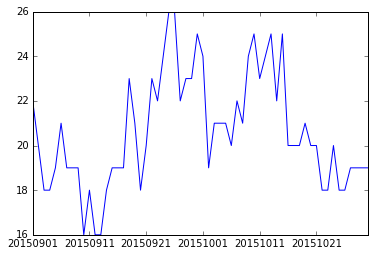

In [36]:
artist.iloc[0,:].plot()

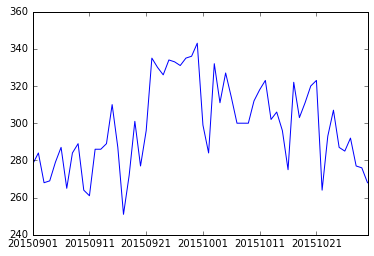

In [37]:
artist.iloc[1,:].plot()

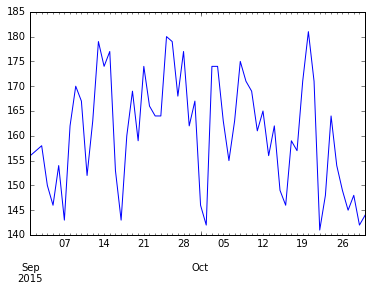

In [18]:
artist.iloc[2,:].plot()

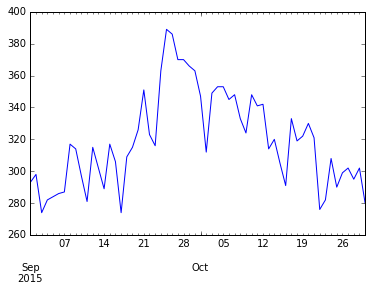

In [19]:
artist.iloc[3,:].plot()

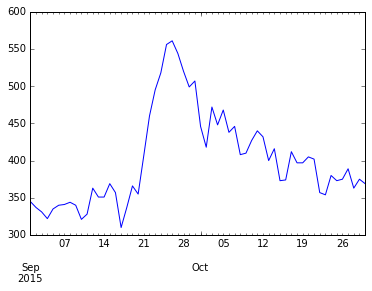

In [20]:
artist.iloc[4,:].plot()

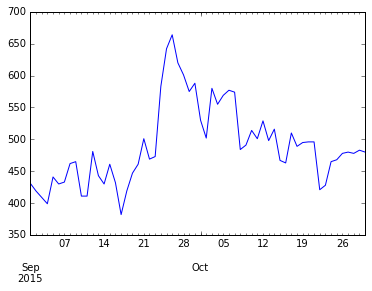

In [21]:
artist.iloc[5,:].plot()

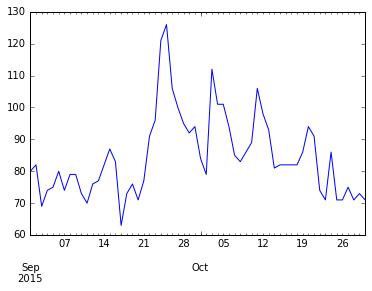

In [22]:
artist.iloc[6,:].plot()

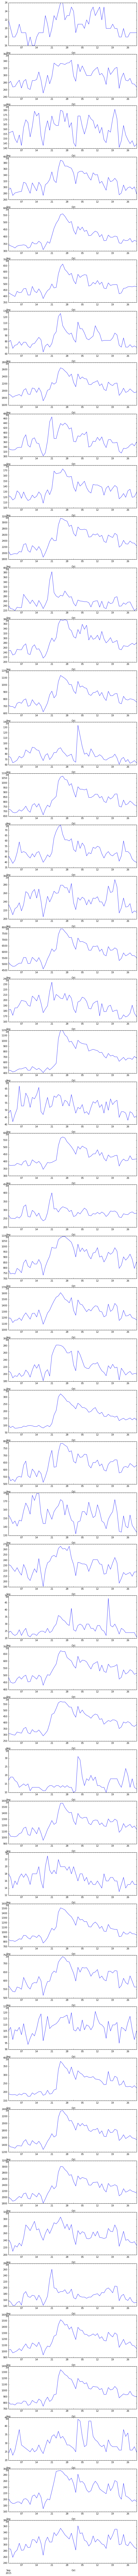

In [23]:
fig, axes = plt.subplots(50,1, figsize=(10,200))
for i in range(50):
    artist.iloc[i,:].plot(ax=axes[i])

In [38]:
# artist.columns = artist.columns.map(lambda x: x.date())
artist.stack().to_csv('submit.csv')

In [102]:
artist.sum(axis=1).sort_values()

artist_id
9f69ffd8852196e02cfa19b5cd9bc432      1010
b6a175a48743caed6d035444c069ab64      1025
023406156015ef87f99521f3b343f71f      1404
8fb3cef29f2c266af4c9ecef3b780e97      1484
f5a5373f30de984e9142a206f94a2f46      1755
40bbb0da5570702dd6ff3af5e9e3aea6      2549
53dd7de874e0999634c28cdd94d21257      3529
3964ee41d4e2ade1957a9135afe1b8dc      4406
1731019fbaa825714d5f8e61ad1bb7ff      4661
bf21d16799b240d6e445fa30472bd50b      6301
2b7fedeea967becd9408b896de8ff903      6995
8da51d03b8b8717431e8b902856fb45e      9012
7e0db58c13d033dafe5f5e1e70ff7eb4      9067
d773376e46311393cd89994bf9a93043      9423
03c6699ea836decbc5c8fc2dbae7bd3b     10452
4ee3f9c90101073c99d5440b41f07daa     11478
c026b84e8f23a7741d9b670e3d8973f0     11544
f6e0f05fde7637afb8f8bc6bda74ca24     12392
8f29cbc2a555034643d66f9e83dd7a7a     12510
6f462b173b2d6d20a2c9fb1ec0fd2dda     13240
445a257964b9689f115a69e8cc5dcb75     14000
2ec1450a1389d4e3fc2a9a76c9378bb3     14463
ca6db6d4f02b7b946c57fc389e67dd7e     14894
0

In [109]:
song[song.artist_id=='2e14d32266ee6b4678595f8f50c369ac']

,song_id,artist_id,publish_time,song_init_plays,Language,Gender,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
song_id,,,,,,,,,,,,
8c0af7b6cb812288cee966a8fa4bb0d4,8c0af7b6cb812288cee966a8fa4bb0d4,2e14d32266ee6b4678595f8f50c369ac,19961220,7244,11,1,NaN,NaN,NaN,NaN,NaN,NaN
7c681d27bf5d684f2c188611653ebf0f,7c681d27bf5d684f2c188611653ebf0f,2e14d32266ee6b4678595f8f50c369ac,19961220,2420338,11,1,NaN,NaN,NaN,NaN,NaN,NaN
43859bd7584a7aa43a28a7b05def5171,43859bd7584a7aa43a28a7b05def5171,2e14d32266ee6b4678595f8f50c369ac,19951222,10055,11,1,NaN,NaN,NaN,NaN,NaN,NaN
dbf76bdb58c5249c5c94acf59a6ccb71,dbf76bdb58c5249c5c94acf59a6ccb71,2e14d32266ee6b4678595f8f50c369ac,19951222,4325,11,1,NaN,NaN,NaN,NaN,NaN,NaN
2af2818aad07f8725188b43a01fc9a6c,2af2818aad07f8725188b43a01fc9a6c,2e14d32266ee6b4678595f8f50c369ac,19951222,3807,11,1,NaN,NaN,NaN,NaN,NaN,NaN
8c508dfa4dce1e62c8e932651f395df5,8c508dfa4dce1e62c8e932651f395df5,2e14d32266ee6b4678595f8f50c369ac,19950509,9138,11,1,NaN,NaN,NaN,NaN,NaN,NaN
2d81384605726b0bb2cf63208ba5ddd7,2d81384605726b0bb2cf63208ba5ddd7,2e14d32266ee6b4678595f8f50c369ac,19950509,2888,11,1,NaN,NaN,NaN,NaN,NaN,NaN
a1d22987106e889ec73143f56dca538b,a1d22987106e889ec73143f56dca538b,2e14d32266ee6b4678595f8f50c369ac,19940615,4699,11,1,NaN,NaN,NaN,NaN,NaN,NaN
8c8b30ec87c2e79245e48fd67e9eb199,8c8b30ec87c2e79245e48fd67e9eb199,2e14d32266ee6b4678595f8f50c369ac,19891110,1482,1,1,NaN,NaN,NaN,NaN,NaN,NaN
